In [2]:
# code to mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# change directory to where csv file is located
%cd drive/MyDrive/'Colab Notebooks'

/content/drive/MyDrive/Colab Notebooks


In [4]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [5]:
# Load Data
health_df = pd.read_excel("2023_County_Health_Rankings_Adj.xlsx", sheet_name="Ranked Measure Data", header=1)
additional_df = pd.read_excel("2023_County_Health_Rankings_Adj.xlsx", sheet_name="Additional Measure Data", header=1)
rucc_df = pd.read_excel("Ruralurbancontinuumcodes2023.xlsx")

# Merge datasets
health_df['FIPS'] = health_df['FIPS'].astype(int)
rucc_df['FIPS'] = rucc_df['FIPS'].astype(int)
df = pd.merge(health_df, rucc_df[['FIPS', 'RUCC_2023']], on="FIPS", how="left")
additional_df['FIPS'] = additional_df['FIPS'].astype(int)
df = pd.merge(df, additional_df[['FIPS', '% Adults with Diabetes']], on='FIPS', how='left')

In [6]:
# Rename columns
df = df.rename(columns={
    '% Adults with Obesity': 'Obesity',
    '% Physically Inactive': 'Inactive',
    '% Adults with Diabetes': 'Diabetes',
    '% Fair or Poor Health': 'PoorHealth',
    'Years of Potential Life Lost Rate': 'YPLL',
    '% Adults Reporting Currently Smoking': 'Smoking',
    '% Excessive Drinking': 'Drinking',
    'Primary Care Physicians Rate': 'PCP_Rate',
    'Food Environment Index': 'FoodEnv',
    '% With Access to Exercise Opportunities': 'ExerciseAccess',
    'Mental Health Provider Rate': 'MentalHealth_Rate',
    'RUCC_2023': 'Urbanization_Level'
})

# Clean and calculate variables
df_clean = df.dropna(subset=[
    'Obesity', 'Inactive', 'Diabetes', 'YPLL',
    'Smoking', 'Drinking', 'PoorHealth', 'Urbanization_Level',
    'PCP_Rate', 'ExerciseAccess', 'FoodEnv', 'MentalHealth_Rate'
]).copy()

df_clean['log_YPLL'] = np.log1p(df_clean['YPLL'])

In [7]:
# Aggregate Index Creation
df_clean['Health_Disadvantage_Index'] = (
    df_clean['Obesity'] + df_clean['PoorHealth'] + df_clean['Diabetes'] + df_clean['log_YPLL']
)
df_clean['Lifestyle_Risk_Index'] = (
    df_clean['Obesity'] + df_clean['Inactive'] + df_clean['Smoking'] + df_clean['Drinking']
)
df_clean['Access_Support_Index'] = (
    df_clean['PCP_Rate'] + df_clean['ExerciseAccess'] + df_clean['FoodEnv'] + df_clean['MentalHealth_Rate']
)

<ipython-input-8-07ce73d62562>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df_all, palette='viridis')


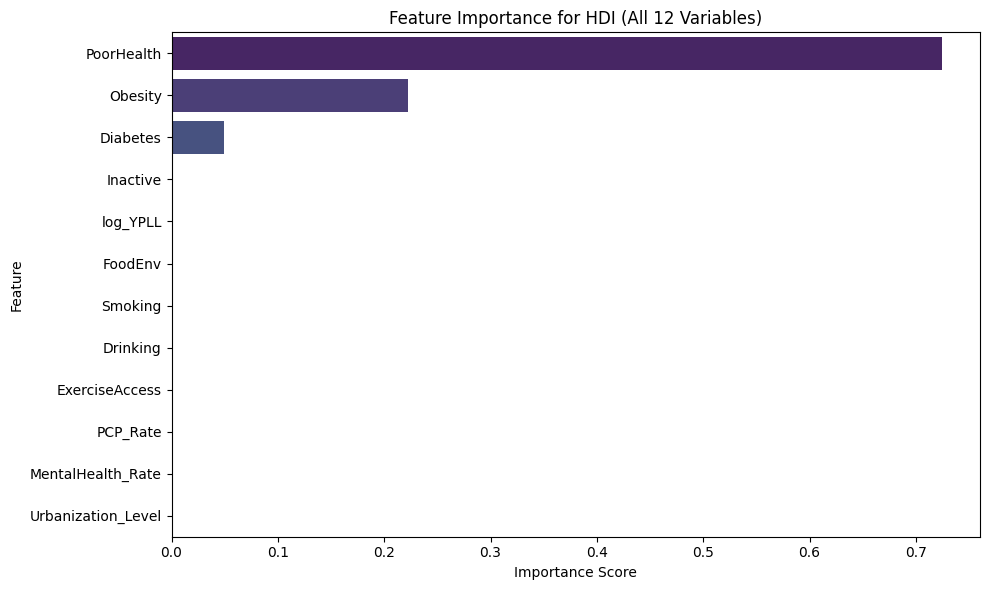

In [8]:
# Random Forest for HDI using all 12 variables (including HDI components)
features = [
    'Obesity', 'PoorHealth', 'Diabetes', 'log_YPLL',
    'Inactive', 'Smoking', 'Drinking',
    'PCP_Rate', 'ExerciseAccess', 'FoodEnv', 'MentalHealth_Rate',
    'Urbanization_Level'
]

X = df_clean[features]
y = df_clean['Health_Disadvantage_Index']

rf_model_all = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_all.fit(X, y)

# Feature Importance Plot
importances_all = rf_model_all.feature_importances_
importance_df_all = pd.DataFrame({'Feature': features, 'Importance': importances_all}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_all, palette='viridis')
plt.title("Feature Importance for HDI (All 12 Variables)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

<ipython-input-9-750176ab3d3b>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


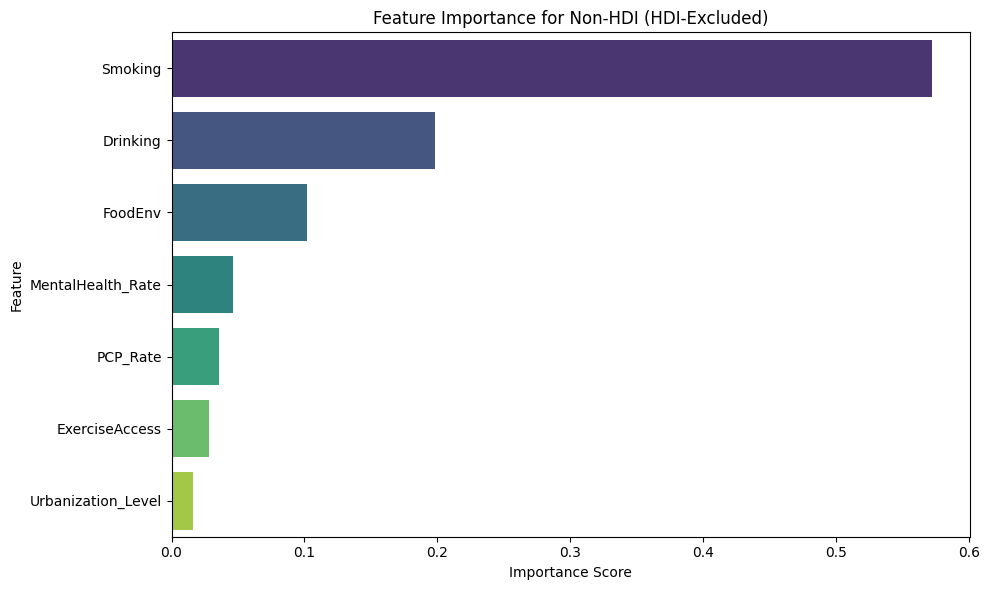

In [9]:
# Random Forest for Non-HDI
features = [
    'Smoking', 'Drinking',
    'PCP_Rate', 'ExerciseAccess', 'FoodEnv', 'MentalHealth_Rate',
    'Urbanization_Level'
]


X = df_clean[features]
y = df_clean['Health_Disadvantage_Index']

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Feature Importance Plot
importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("Feature Importance for Non-HDI (HDI-Excluded)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

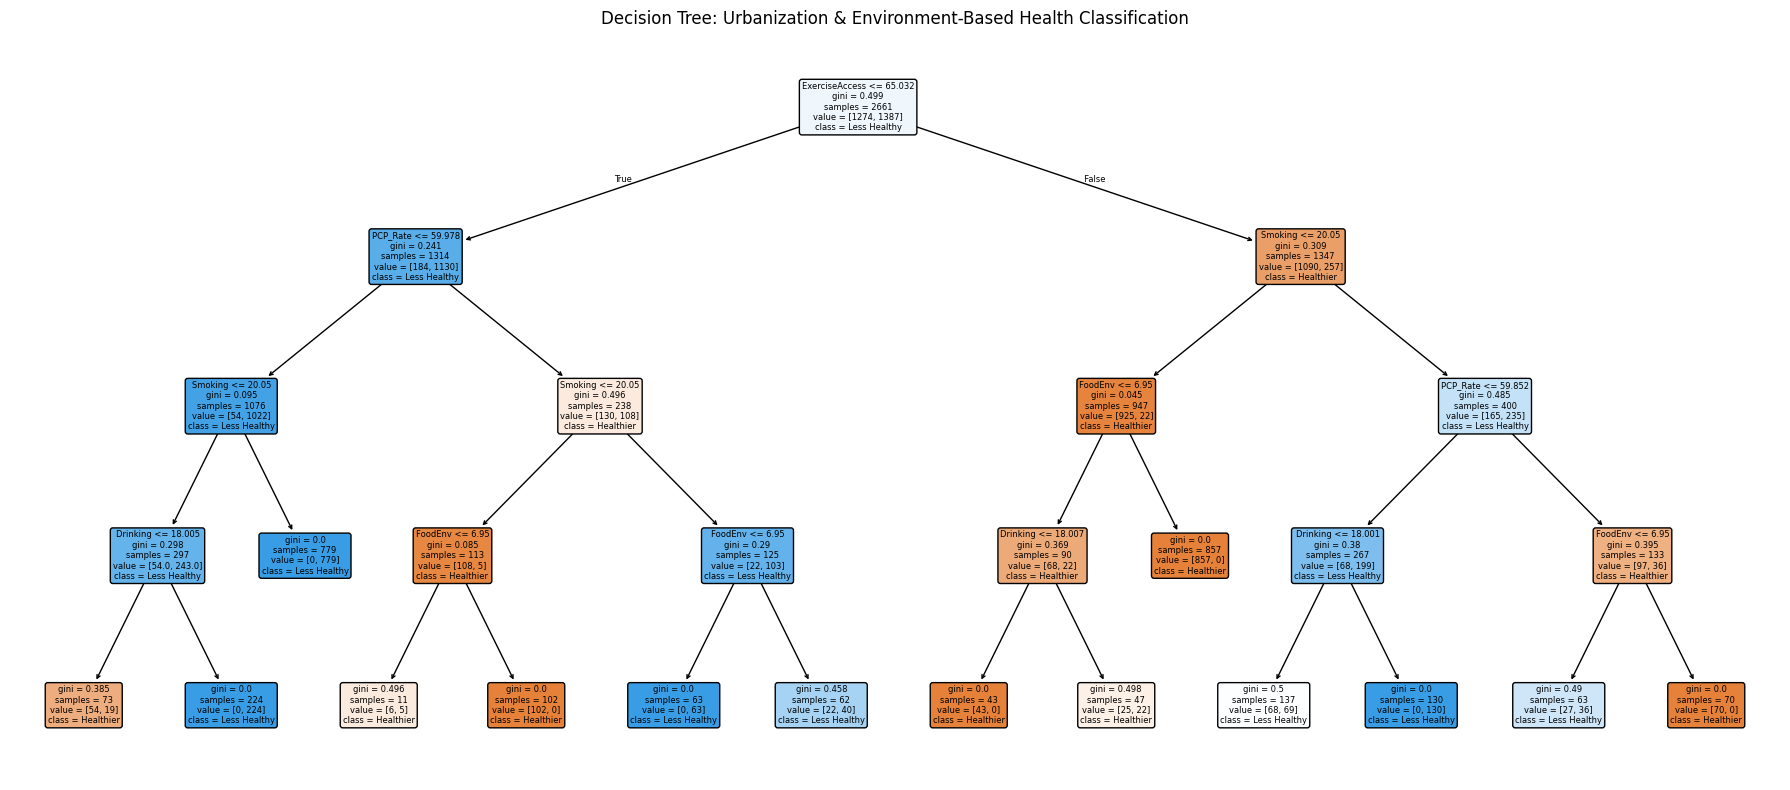

In [10]:
# FINAL DECISION TREE (Urbanization + Non-Obvious Predictors Only)
# Define less obvious predictors
tree_vars = ['Smoking', 'Drinking', 'PCP_Rate', 'ExerciseAccess', 'FoodEnv', 'Urbanization_Level']
df_tree = df_clean.dropna(subset=tree_vars).copy()

# Create custom binary label for “Less Healthy” based on thresholds
conditions = [
    df_tree['Smoking'] > 20,
    df_tree['Drinking'] > 18,
    df_tree['PCP_Rate'] < 60,
    df_tree['ExerciseAccess'] < 65,
    df_tree['FoodEnv'] < 7
]

df_tree['Unhealthy'] = (sum(conditions) >= 3).astype(int)

# Recode RUCC into Urban Class
df_tree['Urban_Class'] = df_tree['Urbanization_Level'].apply(
    lambda x: 'Urban' if x in [1, 2, 3] else ('Suburban' if x in [4, 5, 6] else 'Rural')
)
df_tree['Urban_Code'] = df_tree['Urban_Class'].astype('category').cat.codes

# Define final features for decision tree
final_inputs = ['Urban_Code', 'Smoking', 'Drinking', 'PCP_Rate', 'ExerciseAccess', 'FoodEnv']
X_final = df_tree[final_inputs]
y_final = df_tree['Unhealthy']

# Fit and plot decision tree
tree_final = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_final.fit(X_final, y_final)

plt.figure(figsize=(18, 8))
plot_tree(tree_final, feature_names=final_inputs, class_names=["Healthier", "Less Healthy"], filled=True, rounded=True)
plt.title("Decision Tree: Urbanization & Environment-Based Health Classification")
plt.tight_layout()
plt.show()

<ipython-input-11-1bc6d3f8fc48>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Urbanization_Level', y='Health_Disadvantage_Index', data=df_clean, palette='Reds', errorbar='sd')


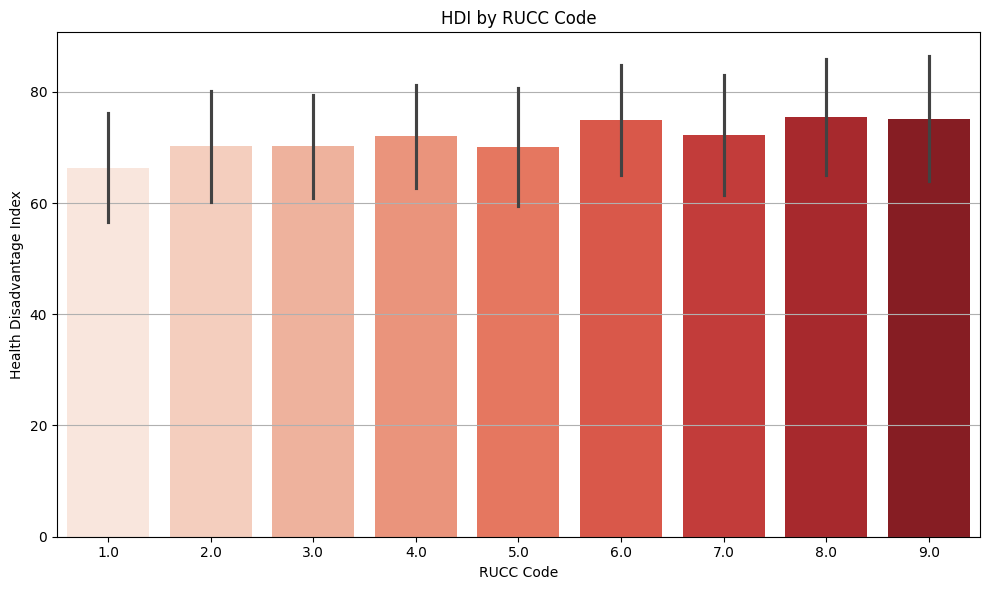

<ipython-input-11-1bc6d3f8fc48>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Urbanization_Level', y='Lifestyle_Risk_Index', data=df_clean, palette='Blues', errorbar='sd')


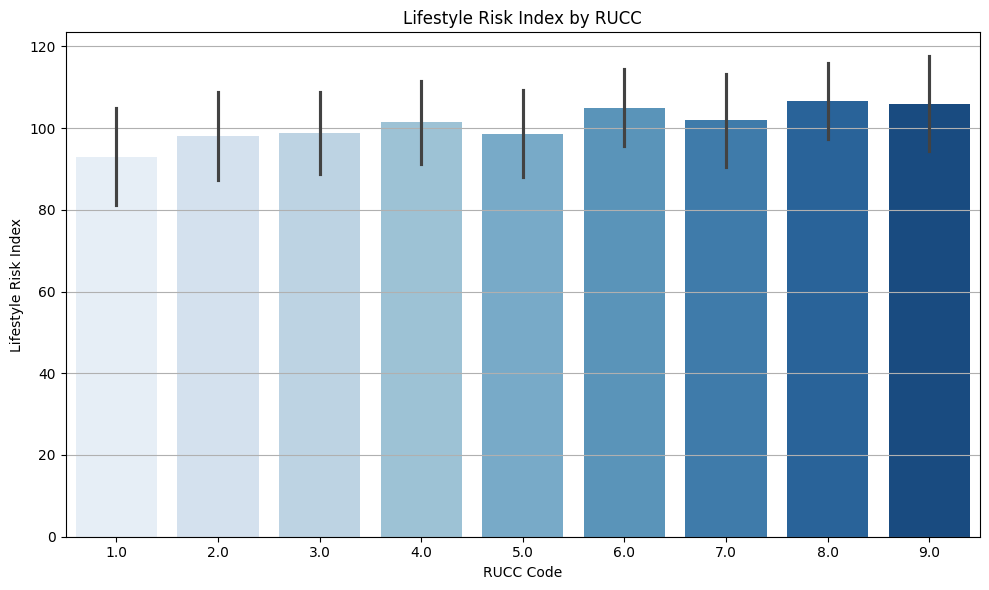

<ipython-input-11-1bc6d3f8fc48>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Urbanization_Level', y='Access_Support_Index', data=df_clean, palette='Greens', errorbar='sd')


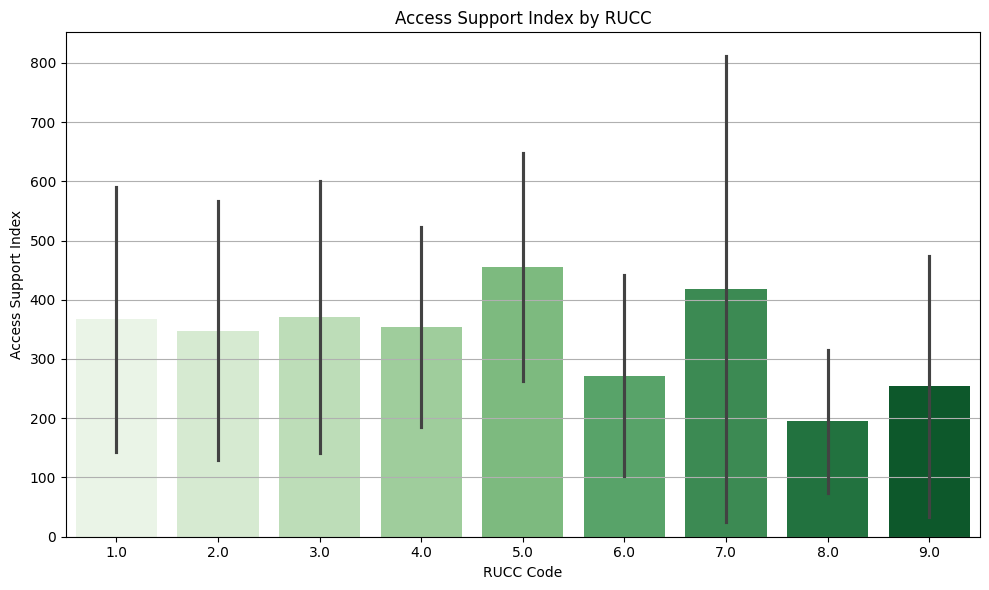

In [11]:
# Barplots of Indices (Optional)
plt.figure(figsize=(10, 6))
sns.barplot(x='Urbanization_Level', y='Health_Disadvantage_Index', data=df_clean, palette='Reds', errorbar='sd')
plt.title("HDI by RUCC Code")
plt.xlabel("RUCC Code")
plt.ylabel("Health Disadvantage Index")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Urbanization_Level', y='Lifestyle_Risk_Index', data=df_clean, palette='Blues', errorbar='sd')
plt.title("Lifestyle Risk Index by RUCC")
plt.xlabel("RUCC Code")
plt.ylabel("Lifestyle Risk Index")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Urbanization_Level', y='Access_Support_Index', data=df_clean, palette='Greens', errorbar='sd')
plt.title("Access Support Index by RUCC")
plt.xlabel("RUCC Code")
plt.ylabel("Access Support Index")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [12]:
# Choropleth Maps
df_clean['FIPS'] = df_clean['FIPS'].astype(str).str.zfill(5)

fig_hdi = px.choropleth(
    df_clean,
    geojson="https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json",
    locations='FIPS',
    color='Health_Disadvantage_Index',
    color_continuous_scale="Reds",
    scope="usa",
    title="HDI by U.S. County"
)
fig_hdi.update_geos(fitbounds="locations", visible=False)
fig_hdi.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig_hdi.show()

def categorize_urbanization(rucc):
    if rucc in [1, 2, 3]: return "Urban"
    elif rucc in [4, 5, 6]: return "Suburban"
    else: return "Rural"

df_clean['Urban_Class'] = df_clean['Urbanization_Level'].apply(categorize_urbanization)

fig_urban = px.choropleth(
    df_clean,
    geojson="https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json",
    locations='FIPS',
    color='Urban_Class',
    color_discrete_map={"Urban": "blue", "Suburban": "orange", "Rural": "green"},
    scope="usa",
    title="County Classification by RUCC Level"
)
fig_urban.update_geos(fitbounds="locations", visible=False)
fig_urban.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig_urban.show()

Health Disadvantage Index Summary:
count    2661.000000
mean       71.820404
std        10.557157
min        40.329600
25%        64.597306
50%        71.210803
75%        78.912426
max       118.645951
Name: Health_Disadvantage_Index, dtype: float64


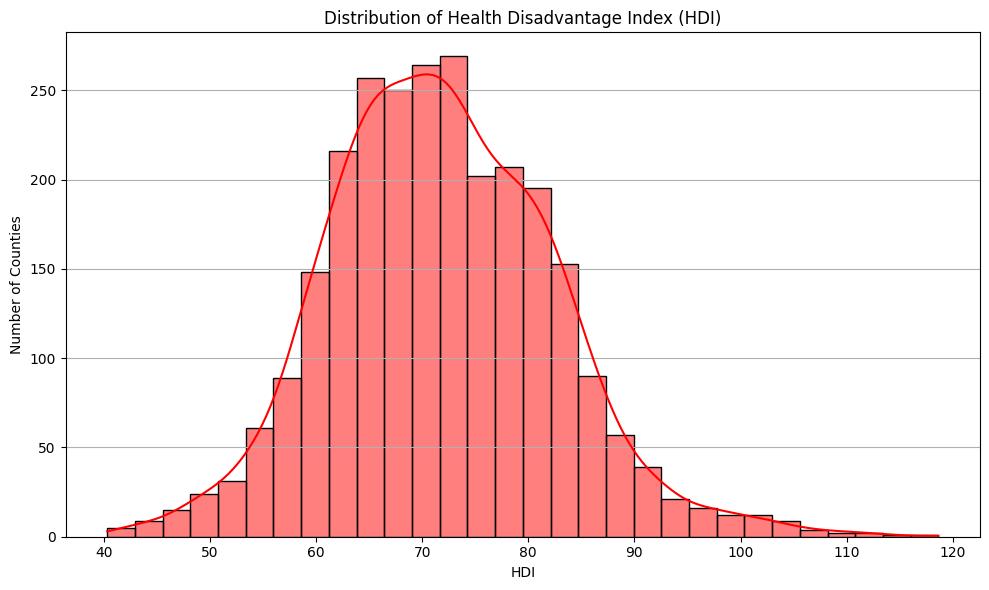

<ipython-input-13-9a2776590453>:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




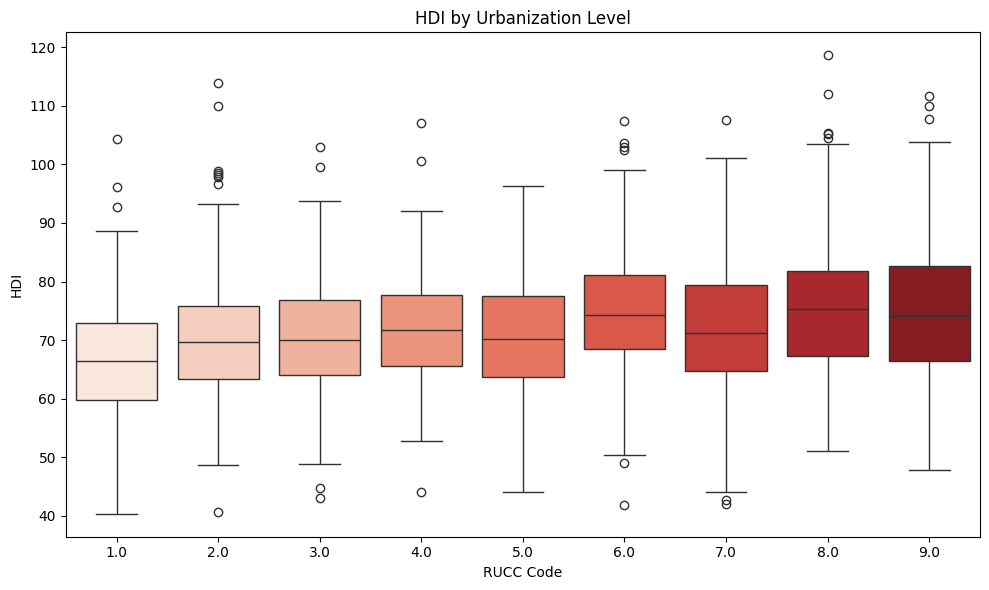

In [13]:
# HDI Summary Stats
print("Health Disadvantage Index Summary:")
print(df_clean['Health_Disadvantage_Index'].describe())

# HDI Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['Health_Disadvantage_Index'], bins=30, kde=True, color='red')
plt.title("Distribution of Health Disadvantage Index (HDI)")
plt.xlabel("HDI")
plt.ylabel("Number of Counties")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# HDI vs RUCC Scatter
plt.figure(figsize=(10, 6))
sns.boxplot(x='Urbanization_Level', y='Health_Disadvantage_Index', data=df_clean, palette='Reds')
plt.title("HDI by Urbanization Level")
plt.xlabel("RUCC Code")
plt.ylabel("HDI")
plt.tight_layout()
plt.show()

Lifestyle Risk Index Summary:
count    2661.000000
mean      100.908355
std        11.583566
min        55.446836
25%        94.313381
50%       101.780515
75%       108.637501
max       147.892874
Name: Lifestyle_Risk_Index, dtype: float64


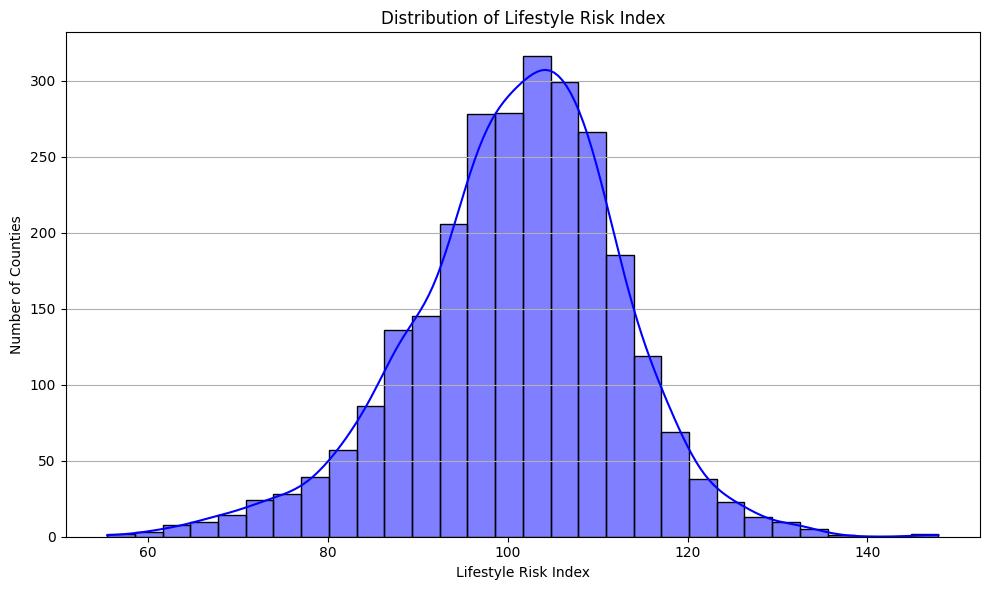

<ipython-input-14-8b721ae44442>:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




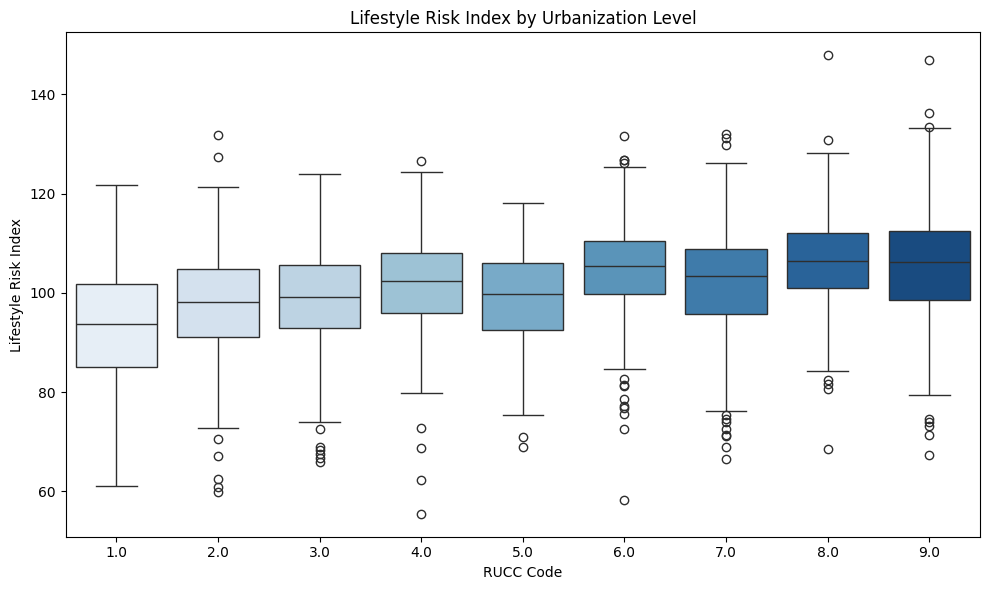

In [14]:
# Lifestyle Risk Summary Stats
print("Lifestyle Risk Index Summary:")
print(df_clean['Lifestyle_Risk_Index'].describe())

# Lifestyle Risk Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['Lifestyle_Risk_Index'], bins=30, kde=True, color='blue')
plt.title("Distribution of Lifestyle Risk Index")
plt.xlabel("Lifestyle Risk Index")
plt.ylabel("Number of Counties")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Lifestyle Risk by Urbanization
plt.figure(figsize=(10, 6))
sns.boxplot(x='Urbanization_Level', y='Lifestyle_Risk_Index', data=df_clean, palette='Blues')
plt.title("Lifestyle Risk Index by Urbanization Level")
plt.xlabel("RUCC Code")
plt.ylabel("Lifestyle Risk Index")
plt.tight_layout()
plt.show()


Access Support Index Summary:
count    2661.000000
mean      322.542663
std       234.300305
min        32.197278
25%       168.246814
50%       266.732227
75%       406.114515
max      3151.236317
Name: Access_Support_Index, dtype: float64


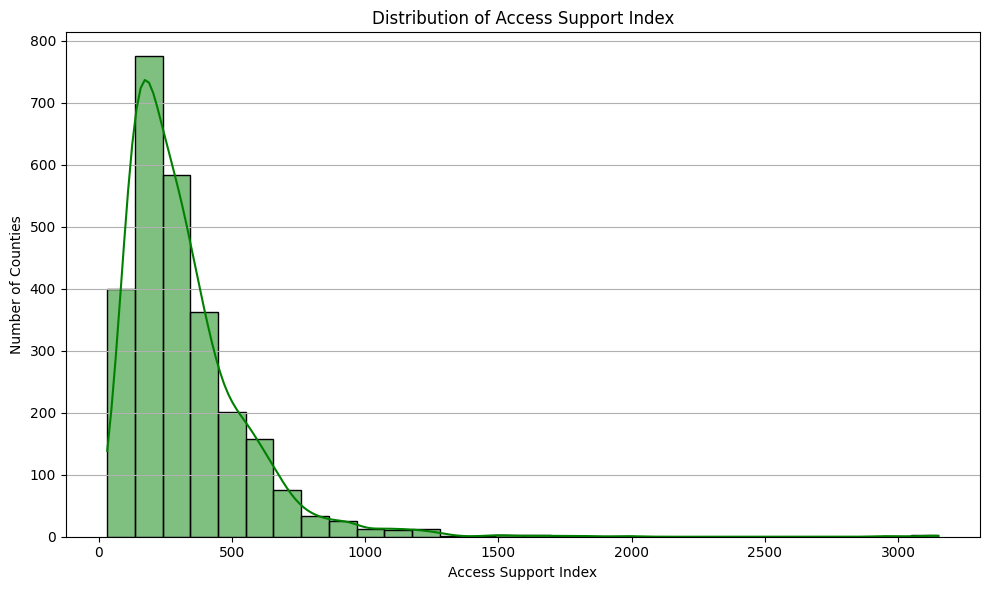

<ipython-input-15-1597dc908483>:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




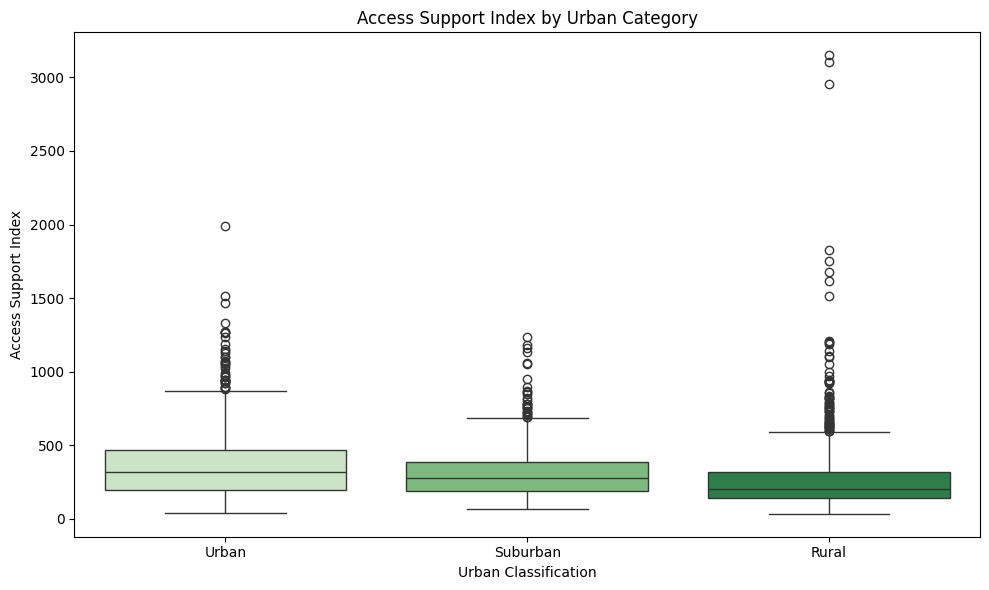

In [15]:
# Access Support Summary Stats
print("Access Support Index Summary:")
print(df_clean['Access_Support_Index'].describe())

# Access Support Index Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['Access_Support_Index'].dropna(), bins=30, kde=True, color='green')
plt.title("Distribution of Access Support Index")
plt.xlabel("Access Support Index")
plt.ylabel("Number of Counties")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Access Index by Urban Class (Boxplot)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Urban_Class', y='Access_Support_Index', data=df_clean, palette='Greens')
plt.title("Access Support Index by Urban Category")
plt.xlabel("Urban Classification")
plt.ylabel("Access Support Index")
plt.tight_layout()
plt.show()


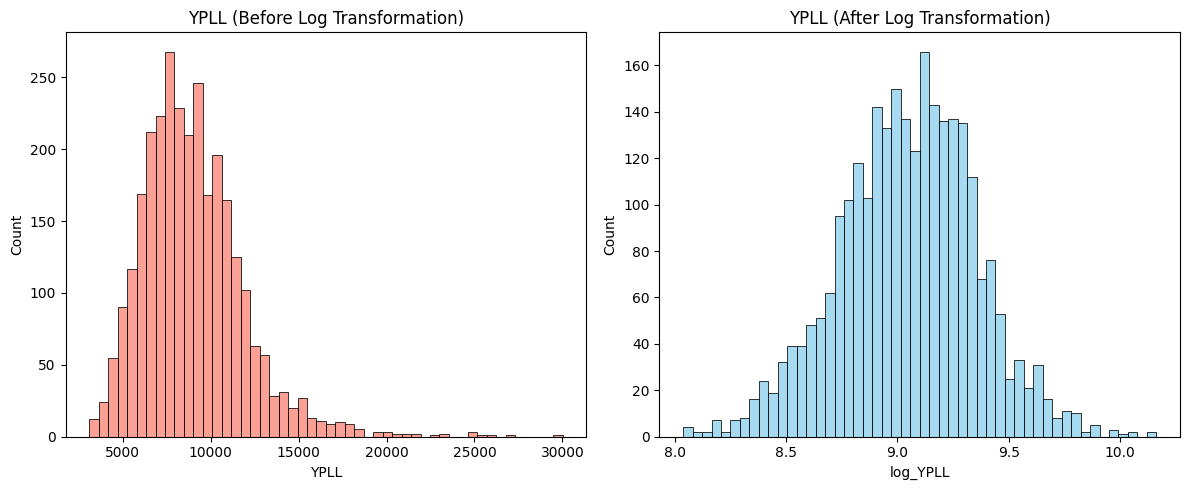

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# Before log transformation
plt.subplot(1, 2, 1)
sns.histplot(df['YPLL'], bins=50, color='salmon', edgecolor='black')
plt.title("YPLL (Before Log Transformation)")
plt.xlabel("YPLL")
plt.ylabel("Count")

# After log transformation
plt.subplot(1, 2, 2)
sns.histplot(df_clean['log_YPLL'], bins=50, color='skyblue', edgecolor='black')
plt.title("YPLL (After Log Transformation)")
plt.xlabel("log_YPLL")
plt.ylabel("Count")

plt.tight_layout()
plt.show()
